# 基于 XGBoost 的糖尿病预测模型（Pima Indians Diabetes）

## 知识点
- XGBoost 是 Gradient Boosting 的高效实现；
- 在目标函数中加入正则项，有助于抑制过拟合。

## 实验目的
1) 学习建立 XGBoost 模型解决糖尿病预测问题；
2) 学习使用网格搜索优化 XGBoost 模型超参数。

## 实验步骤概览
1) 读取数据并查看前 5 行；
2) 数据描述与可视化（统计描述、缺失值、直方图、散点矩阵）；
3) 划分训练集与测试集；
4) 训练基础 XGBoost 模型并评估（测试集、10 折交叉验证）；
5) 使用 GridSearchCV 调参并训练“最优”模型；
6) 再次评估并总结结论。

In [6]:
# Code 001: 读取数据
import pandas as pd

df = pd.read_csv('pima-indians-diabetes.data.csv')

df.head()

,preg,plas,pres,skin,test,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
# Code 002/003: 数据描述与缺失值
print('Describe:')
display(df.describe())

print('\nMissing values per column:')
display(df.isnull().sum())

Describe:


,preg,plas,pres,skin,test,mass,pedi,age,class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000



Missing values per column:


preg     0
plas     0
pres     0
skin     0
test     0
mass     0
pedi     0
age      0
class    0
dtype: int64

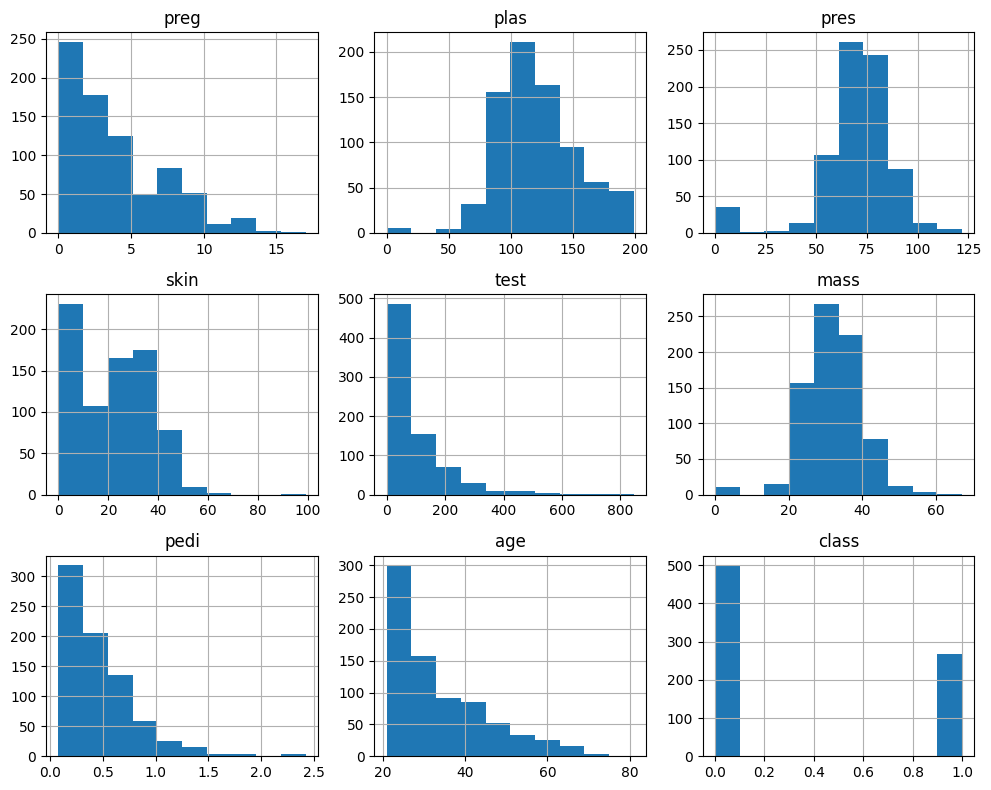

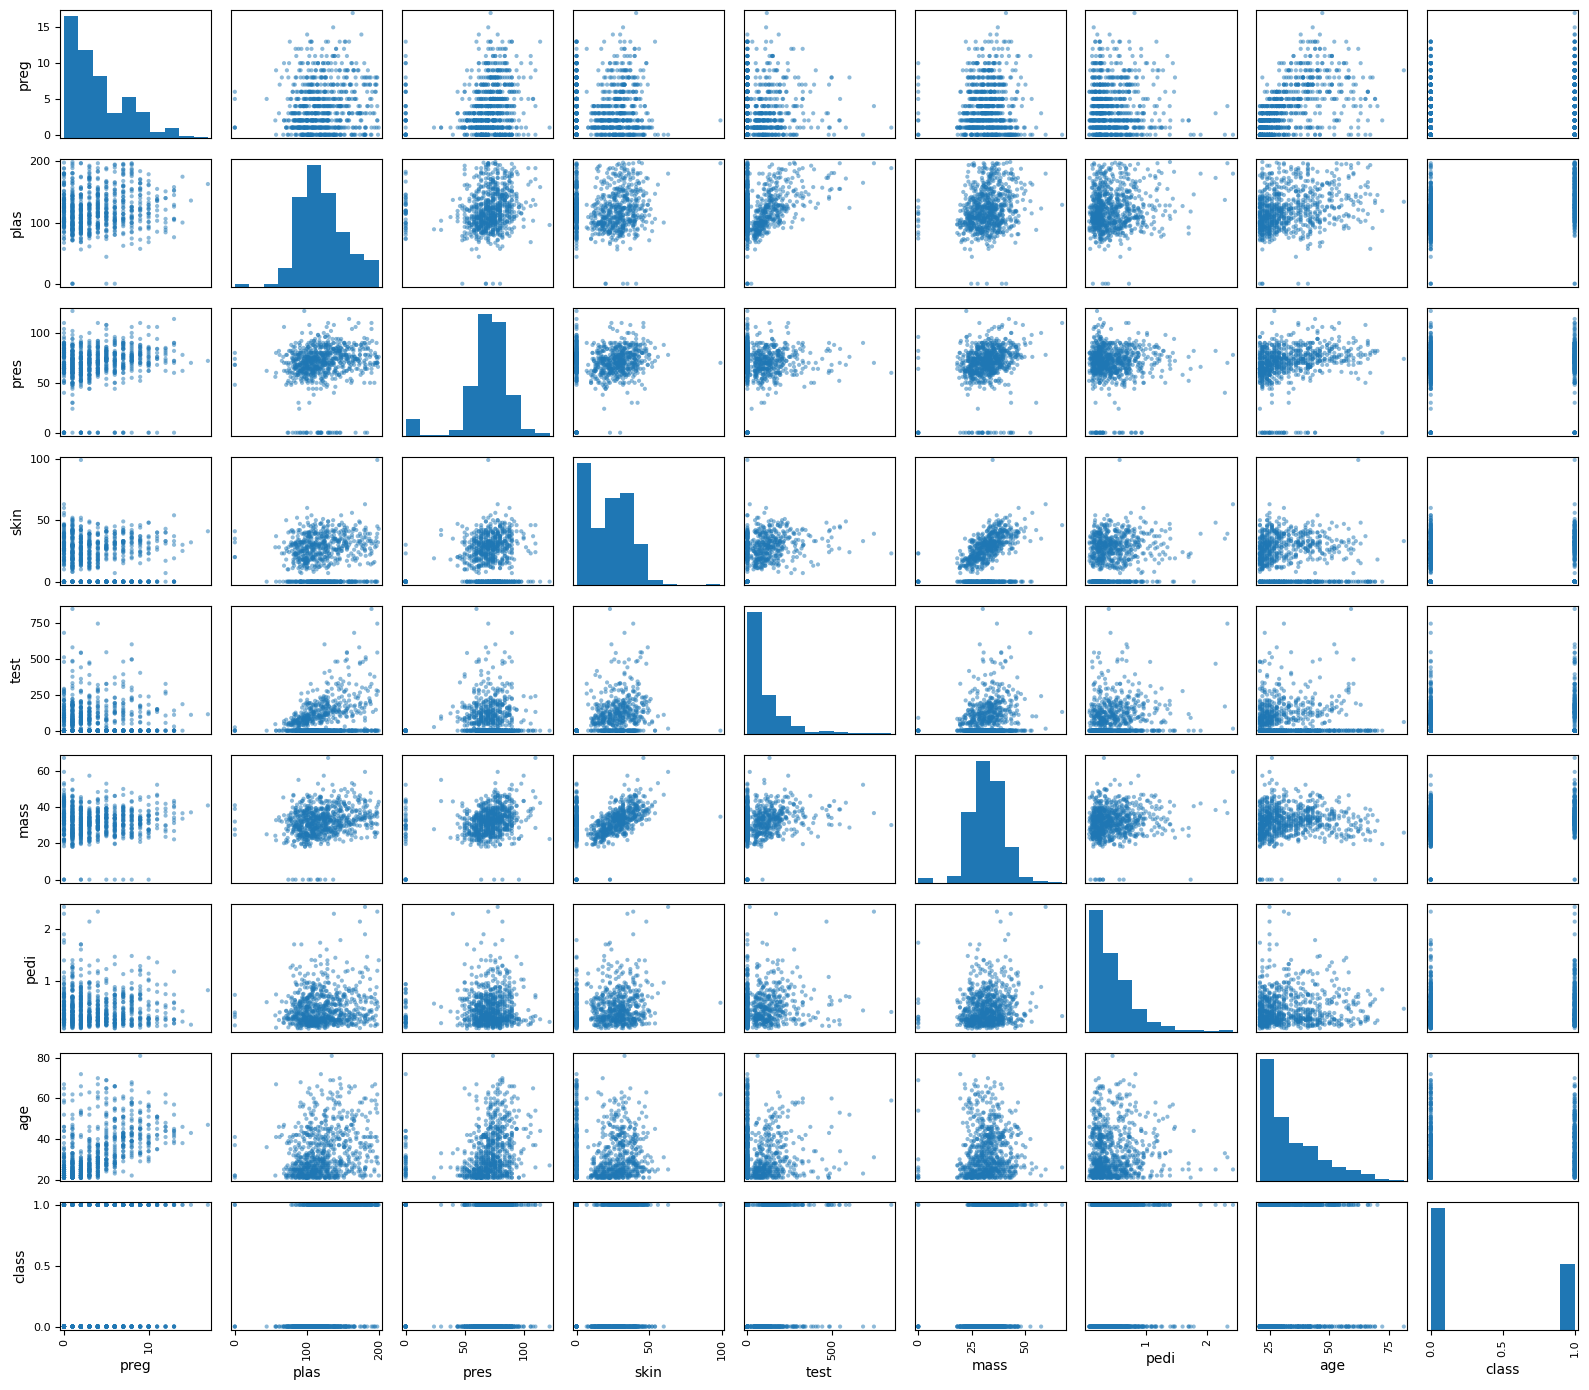

In [8]:
# Code 004/005: 可视化（直方图与散点矩阵）
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# 直方图
_ = df.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

# 散点矩阵
_ = scatter_matrix(df, figsize=(16, 14))
plt.tight_layout()
plt.show()

In [9]:
# Code 006: 数据预处理与划分
from sklearn.model_selection import train_test_split

X = df.loc[:, df.columns != 'class']
y = df.loc[:, 'class']  # 使用一维 Series

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_tr.shape, X_ts.shape

((576, 8), (192, 8))

In [10]:
# Code 007: 训练基础 XGBoost 模型
from xgboost import XGBClassifier

# 使用较稳定的一组基础参数并设定随机种子
default_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=1.0,
    colsample_bytree=1.0,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

model = default_model.fit(X_tr, y_tr)
model

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1.0
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [11]:
# Code 008/009: 测试集评估与 10 折交叉验证
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import cross_val_score
import warnings

warnings.filterwarnings('ignore')

# 测试集评估
y_pred = model.predict(X_ts)
print('Test set:')
print('  f1-score: %.4f' % f1_score(y_ts, y_pred))
print('  accuracy: %.4f' % accuracy_score(y_ts, y_pred))

# 10 折交叉验证（在全量数据上）
scores = cross_val_score(model, X, y, cv=10, scoring='f1')
print('\n10-fold CV f1-score: %.4f' % scores.mean())

Test set:
  f1-score: 0.6250
  accuracy: 0.7500

10-fold CV f1-score: 0.6324

10-fold CV f1-score: 0.6324


In [12]:
# Code 010/011/012: 网格搜索优化与最优模型评估
from sklearn.model_selection import GridSearchCV
import numpy as np

params = {
    'min_child_weight': list(range(6, 15, 2)),
    'max_depth': list(range(3, 8, 1)),
    'n_estimators': list(range(40, 81, 10))
}

base = XGBClassifier(learning_rate=0.03, random_state=42, n_jobs=-1, eval_metric='logloss')

gs = GridSearchCV(
    estimator=base,
    param_grid=params,
    scoring='f1',
    cv=4,
    n_jobs=-1,
    return_train_score=True,
    verbose=1
)

gs.fit(X_tr, y_tr)

print('Best params:', gs.best_params_)
print('Best CV f1-score:', gs.best_score_)

clf = gs.best_estimator_
clf.fit(X_tr, y_tr)

cv_scores = cross_val_score(clf, X, y, cv=5, scoring='f1')
print('Best estimator 5-fold CV f1-score: %.4f' % cv_scores.mean())

Fitting 4 folds for each of 125 candidates, totalling 500 fits
Best params: {'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 80}
Best CV f1-score: 0.6391423485549295
Best params: {'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 80}
Best CV f1-score: 0.6391423485549295
Best estimator 5-fold CV f1-score: 0.6288
Best estimator 5-fold CV f1-score: 0.6288


## 实验结论

- XGBoost 作为梯度提升树的高效实现，通常能在该数据集上取得优于单一树模型的性能；
- 通过加入正则与合适的超参数（max_depth、min_child_weight、n_estimators 等），可有效控制过拟合；
- 使用 GridSearchCV 搜索后得到的“最优”模型，在交叉验证 f1-score 上通常优于基础模型；
- 实际数值会因随机种子、划分比例、库版本而有所差异，建议固定 random_state 以增强复现性。